## SMOTE upsampling

This is a set of functions that facilitates the upsampling of the minority class with missing values using SMOTE. The ultimate goal of upsampling here is two-fold:
- decrease the class imbalance for better classifier performance
- approximate the lookback length distribution of the positives to the scoring 

The function requires two inputs:
- a data frame with the positive matrix
- a column with a sufficiently large sample of scoring lookback lengths



In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import squareform, pdist
%matplotlib inline
%cd ../

F:\Daniel\lookback_matching


## Functions to find nearest neighbours

In [2]:
def get_full_data(df):
    """
    Extracts full columns and returns them standardised to zero
    mean and unit variance.
    """
    
    full_cols = df.columns[pd.isnull(df).sum() == 0]
    full_df = df[full_cols]
    ss = StandardScaler()
    return ss.fit_transform(full_df.values)


def NN_scikit_missing(df, nn_k=5, metric='cityblock', verbose=True):
    """
    This function takes in a dataframe (n x p) and for each
    sample finds its nn_k nearest neighbours. Importantly
    however, only full columns are used for the distance 
    calculation. The data is standardised before NN. By 
    default the algorithm uses Manhattan distance (dist_p=1),
    but this can be changed to Euclidean (dist_p=2) or any 
    other values. 
    
    Scikit-learn decides automatically (based on the data
    size) which algorithm to use for NN search (brute force,
    KDtree, or BallTree).
    
    Ultimately the function returns a (n x nn_k). 
    """
    
    # equate distance metric to p-distance exponent 
    if metric == "cityblock":
        dist_p = 1
    else:
        dist_p = 2
        
    X = get_full_data(df)
    n, _ = X.shape
    
    # find nearest neighbours
    neigh = NearestNeighbors(algorithm='auto', p=dist_p, n_jobs=-1)
    neigh.fit(X)
    
    to_return = np.zeros((n, nn_k))
    for i in range(n):
        if verbose and i % 25 == 0:
            print("Finding nearest neighbour of sample %d/%d" % 
                  (i, n))
        
        # find closest neighbours
        nns = neigh.kneighbors(X[i,:].reshape(1,-1), nn_k+1, 
                               return_distance=False)
        # closest sample by default is the sample itself
        to_return[i, :] = nns.ravel()[1:]
    
    return to_return


def NN_scipy_missing(df, nn_k=5, metric='cityblock'):
    """
    This function takes in a dataframe (n x p) and for each
    sample finds its nn_k nearest neighbours. Importantly
    however, only full columns are used for the distance 
    calculation. The data is standardised before NN. By 
    default the algorithm uses Manhattan distance (dist_p=1),
    but this can be changed to Euclidean (dist_p=2) or any 
    other values. 
    
    Unlike NN_scikit_missing, this function uses scipy and 
    can be faster for small number of positives. Furthermore,
    this supports a lot of famous distance metrics. By default
    we use the Manhattan distance which is called cityblock 
    here. Other options include:
    ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, 
    ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’,
    ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, 
    ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’,
    ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.
    
    Ultimately the function returns a (n x nn_k). 
    """
    
    X = get_full_data(df)
    d = squareform(pdist(X, 'cityblock'))
    return d.argsort()[:, 1:nn_k+1]

## SMOTE functions

In [3]:
def SMOTE_missing(df, nns, upsample=3):
    """
    This function takes in a dataframe (n x p) and a 
    nearest neighbour matrix (n x nn_k) as returned by
    either NN_scipy_missing or NN_scikit_missing, which
    for each sample holds the nn_k nearest neighs.
    
    When this functuon generates new samples it uses the 
    full sample vector. So if the closest neighbour of 
    sample i has missing values, those will be used for
    creating a new synthetic data point. The non-missing
    values will be multiplied by a random number like in
    the default SMOTE.
    
    The upsample param sets the number of new synthetic 
    positives we want to generate for each positive sample.
    Note, this is done multiple times while we are 
    approximating the two distributions, therefore it should
    be kept fairly small, i.e. less than 5.
    """
    
    # generate row indices for the upsampling so we can
    # subtract samples in matrix form
    n, p = df.shape
    row_ix = []
    row_ix += [[i] * upsample for i in range(n)]
    row_ix = np.array(row_ix).ravel()
    
    
    # use the number of samples we want upsample
    if upsample > nns.shape[1]:
        raise ValueError("upsample cannot be larger than 5.")
    nns = nns[:, :upsample].ravel()
    
    # SMOTE: take the difference between each sample and its 
    # nearest neighbours and multiply this diff vector by a 
    # random number on the range of [0, 1]
    original_samples = df.iloc[row_ix, :].values
    nearest_samples = df.iloc[nns,:].values
    diff_matrix =   nearest_samples - original_samples
    random_weights = np.random.rand(n * upsample)
    random_diff = diff_matrix * random_weights[:, np.newaxis]
    new_samples = original_samples + random_diff
    return pd.DataFrame(new_samples, columns=df.columns)


def hack_for_binary_flags(df, cols, thresh=0.5):
    """
    We don't have a good solution for sythetic categorical vars.
    This hacky solution will turn binary flag columns in a 
    sythetic dataset into zeros and ones. 
    """
    binary_cols = df[cols].copy(deep=True)
    binary_cols[binary_cols >= thresh] = 1
    binary_cols[binary_cols < thresh] = 0
    df.update(binary_cols)
    return df

## Function to approximate two lookback distributions

In [4]:
def approximate_lookbacks(pos_real, pos_smote, neg, bin_width=30):
    """
    Given three lists of lookbacks (in days), this function will
    define the positive lookback as {pos_real U pos_smote}, then
    bin both neg and the pos lookback lists to common bins. See
    bin_width (by default we bin days to months). 
    
    If there are months where we have more synthetic data (as
    density) we discard samples until that's not the case. 
    
    The lookback of the positives is not touched, we only
    discard smote positive samples to approximate the 
    lookback of the 
    
    pos_real: lookback of the positives
    pos_smote: lookback of the synthetic positives
    neg: lookback of the negatives
    bin_width: number of days to use for binning
    """
    # merge pos_real and pos_smote
    pos = list(pos_real) + list(pos_smote)
    
    # record length of lists
    pos_real_n = len(list(pos_real))
    pos_n = len(list(pos))
    neg_n = len(list(neg))
    
    # find the min and max of the real and synthetic lookbacks
    min_d = np.min([np.min(pos), np.min(neg)])
    max_d = np.max([np.max(pos), np.max(neg)])

    # define bins for histogram, by default we use months
    bins = np.arange(min_d, max_d, bin_width)

    # bin lookback days into months
    pos_m = np.digitize(pos, bins)
    neg_m = np.digitize(neg, bins)

    # these will help to keep track of all the sythetic samples 
    # we need to discard
    pos_ix = np.arange(pos_n)
    to_delete = []
    to_delete_n_old = 0

    # get histogram of lookback in months
    pos_h = np.bincount(pos_m, minlength=bins.size + 1)/pos_n
    neg_h = np.bincount(neg_m, minlength=bins.size + 1)/neg_n

    # subtract real histogram from synthetic
    h_diff = pos_h - neg_h

    # until we have more frequent months in sythetic data
    while np.any(h_diff > 0):
        # bins that are higher in smote than real
        pos_higher_ix = np.where(h_diff > 0)[0]
        for bin_ix in pos_higher_ix:
            # samples that are in the examined bin
            ix_in_bin = np.where(pos_m == bin_ix)[0]
            
            # check if we have smote samples in this bin
            if np.any(pos_ix[ix_in_bin] >= pos_real_n):
                # use only the smote samples
                ix_in_bin = ix_in_bin[np.where(pos_ix[ix_in_bin] >= pos_real_n)[0]]
                # choose one randomly 
                ix_to_delete = np.random.choice(ix_in_bin)
                # add it to output vector
                to_delete.append(pos_ix[ix_to_delete])
                
                # delete it from both pos_m and pos_ix to update the distribution
                pos_m = np.delete(pos_m, ix_to_delete)
                pos_ix = np.delete(pos_ix, ix_to_delete)
                # update histogram and hist diff
                pos_h = np.bincount(pos_m, minlength=bins.size + 1)/pos_n
                h_diff = pos_h - neg_h

        # check if are we still making progress, if not, stop
        if len(to_delete) == to_delete_n_old:
            break
        to_delete_n_old = len(to_delete)
    
    # subtract the indecies of the real positives from the list
    to_delete = np.array(to_delete) - pos_real_n
    return to_delete

## Main function of the pipeline

In [5]:
def SMOTE_upsampling(pos, scoring_lookback, pos_lookback_col, 
                     pos_binary_cols, upsample=3, metric='cityblock',  
                     bin_width=30, ks_threshold=0.05, max_iter=50, 
                     nn_algo="scipy", verbose=True):
    """
    This function takes in a dataframe of positive samples
    performs SMOTE on them, while also handling missing 
    data, see docsting of SMOTE_missing.
    
    For nearest neightbour calculation the metric param sets
    the distance metric to use. Have a look at the docstring
    of NN_scipy_missing for all the available options. If 
    you have more than 5000 positives, try changing the 
    nn_algo to "scikit".
    
    Then it merges the synthetic positives with the real
    positives. The lookback lengths are presumed to be in
    days. These are then binned to months by default. This
    can be changed with the bin_width param.
    
    Then it selectively throws away certain synthetic 
    positives to approximate the distribution of the 
    lookbacks of positives to the lookbacks found in 
    scoring_lookback vector. 
    
    ks_threshold is the p-value below which we reject 
    the null hypothesis that the two distributions are from
    the same distribution. Note, here we want the two dist to 
    in fact be similar, so a p-value higher than this threshold
    is desirable. The higher, the more match the two dists. 
    
    max_iter is another way to control how long the algo is
    tryin to match the two distributions. Each iteration 
    consists of a new smote upsampling and matching round,
    where we selectively discard some sythetic positives.
    
    The function returns the new, sythetic positive samples.
    """
    
    # get nearest neighbours
    if nn_algo == "scipy":
        nns = NN_scipy_missing(pos, nn_k=5, metric=metric)
    else:
        nns = NN_scikit_missing(pos, nn_k=5, metric=metric,
                                verbose=verbose)
    
    # extract lookback vectors
    pos_lookback = pos[pos_lookback_col].values
    scoring_lookback = scoring_lookback.values.ravel()
    
    iter_count = 0
    while iter_count < max_iter:
        print(iter_count)
        # run SMOTE to get new synthetic positives
        pos_smote_df = SMOTE_missing(pos, nns, upsample)
        
        # deal with binary flag variables
        pos_smote_df = hack_for_binary_flags(pos_smote_df, pos_binary_cols)
    
        # append new sythetic positves to existing ones
        # and define smote lookback vector
        if 'pos_smote_df_all' in locals():
            pos_smote_df_all = pos_smote_df_all.append(pos_smote_df, 
                                                       ignore_index=True)       
        else:
            pos_smote_df_all = pos_smote_df
        pos_smote_lookback = pos_smote_df_all[pos_lookback_col]
        
        # find out which smote pos we need to delete to make the
        # pos and scoring lookback dist more similar
        to_delete = approximate_lookbacks(pos_lookback, pos_smote_lookback,
                                          scoring_lookback, bin_width)

        # delete rows from synthetic positives we don't need
        pos_smote_df_all.drop(to_delete, inplace=True)
        
        # merge real and synthetic pos lookbacks for testing
        pos_lookback_merged = (list(pos_smote_df_all[pos_lookback_col]) +
                               list(pos[pos_lookback_col]))
        
        # compare the two distributions
        p_val = sp.stats.ks_2samp(pos_lookback_merged, scoring_lookback)[1]
        if p_val > ks_threshold:
            break
        iter_count += 1
        
    return pos_smote_df_all

# Add discriminator to SMOTE

We want to ensure that we're generating positives that actually look like real positives. To achive this, in this experiment, we generate 10k new positives. Then we take the first 1k and make them the negatives, while the original positives the positive class. Then we train an XGBoost on this dataset and predict the left out 9k SMOTE positives to see how many of them look like real positives.

In [255]:
pos = pd.read_csv("data/pos_train_data.csv")
# delete lookback col
pos.drop("LOOKBACK", axis=1, inplace=True)
nns = NN_scipy_missing(pos, nn_k=5)
pos_smote_df = SMOTE_missing(pos, nns, 5)
pos_smote_df = hack_for_binary_flags(pos_smote_df, ["GENDER"])

In [256]:
# Generate 5k positives twice and concatenate them to get 10k new positives
pos_smote_df1 = pos_smote_df
pos_smote_df = SMOTE_missing(pos, nns, 5)
pos_smote_df = hack_for_binary_flags(pos_smote_df, ["GENDER"])
pos_smote_df = pd.concat([pos_smote_df, pos_smote_df1], ignore_index=True)

Ensure that the SMOTE samples have the same variable types as the real ones, i.e. age and date differences are integers, and floats are rounded to 1 decimal place.

In [257]:
pos_smote_df.AGE = pos_smote_df.AGE.apply(np.round, decimals=0)

In [258]:
pos_smote_df.update(pos_smote_df.iloc[:, 2:345].apply(np.round, decimals=1))

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\series.py:1342: RuntimeWarning: invalid value encountered in rint
  result = _values_from_object(self).round(decimals)


In [259]:
pos_smote_df.update(pos_smote_df.iloc[:, 345:1026].apply(np.round, decimals=0))

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\series.py:1342: RuntimeWarning: invalid value encountered in rint
  result = _values_from_object(self).round(decimals)


Train XGBoost on the training dataset

In [260]:
import xgboost
pos_smote1000 = pos_smote_df.iloc[:1000,:]
pos_smote_rest = pos_smote_df.iloc[1000:,:]
X = pd.concat([pos, pos_smote1000], ignore_index=True)
y = np.hstack((np.ones(1000), np.zeros(1000)))
xr = xgboost.XGBClassifier(n_jobs=-1)
xr.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

How many of the 9k samples look like real positives to the model? Pretty small.. 

In [261]:
np.sum(xr.predict(pos_smote_rest)==1)

172

How does the distribution of predicted probabilites look like? Seems like the model is extremely confident that the vast majority of these samples are sythetic, which is true.. But in this case this is bad news as we wanted SMOTE to generate samples that are indistinguishable from the real ones. 

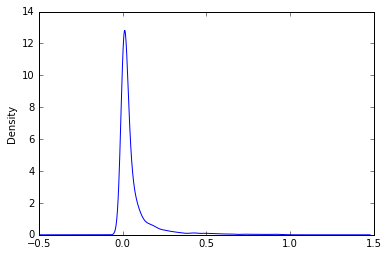

In [262]:
pd.Series(xr.predict_proba(pos_smote_rest)[:,np.argmax(xr.classes_)]).plot(kind="kde")

### Check a few variables 

Checking the top 20 variables which came up as the top predictors in the smote 1000 model. Most of them are fine but some of them are very different. We'll check what's going on later.

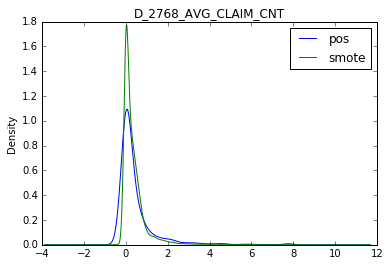

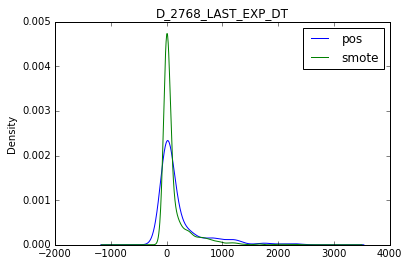

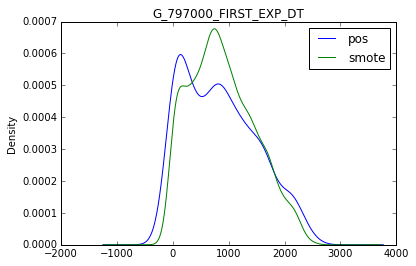

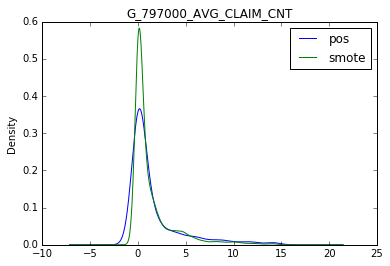

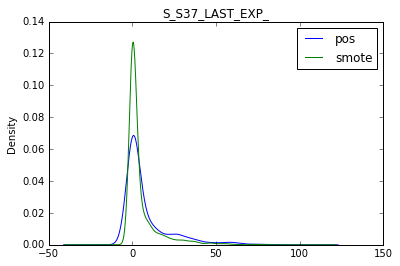

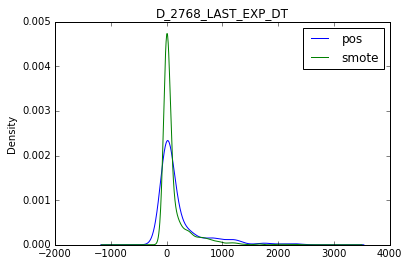

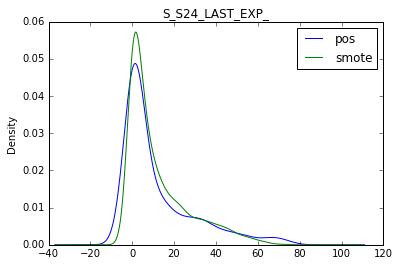

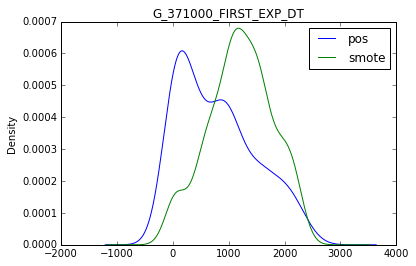

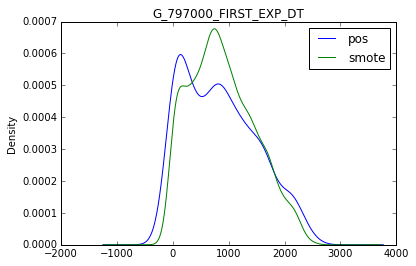

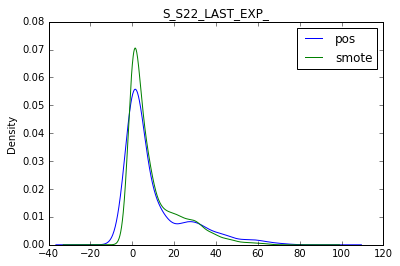

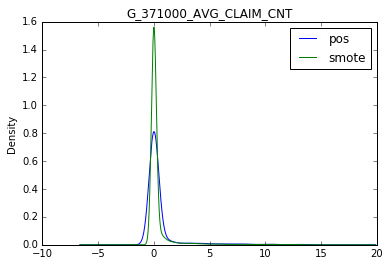

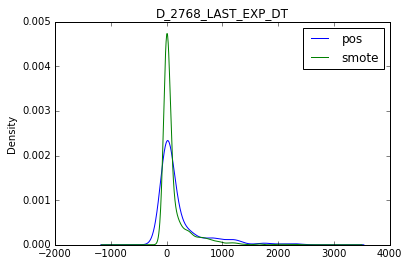

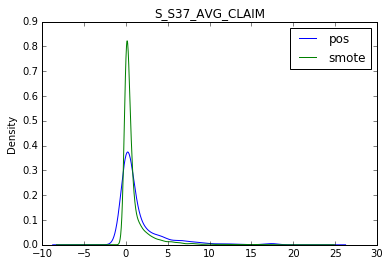

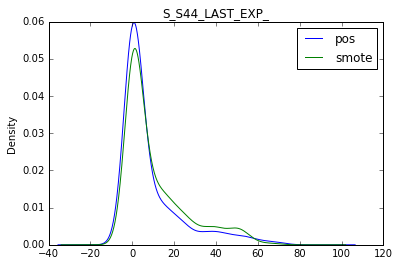

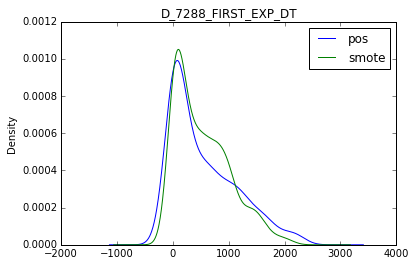

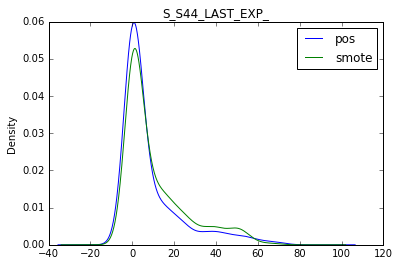

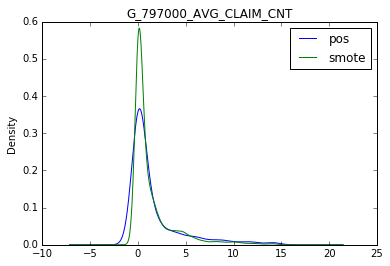

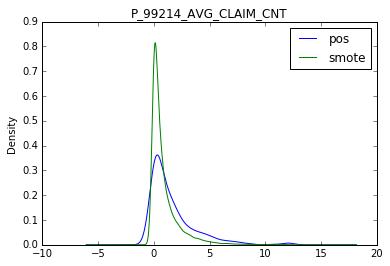

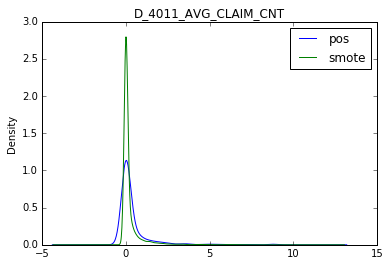

In [213]:
def plot_lookbacks(l1, l2, label1, label2, name):
    to_plot = pd.concat([l1, l2], axis=1)
    to_plot.columns = [label1, label2]
    plot = to_plot.plot(kind="kde", title=name)
    fig = plot.get_figure()
    fig.savefig("pics/originalPos_vs_smotePos_%s.png" % name)

cols = ["D_2768_AVG_CLAIM_CNT",
    "D_2768_LAST_EXP_DT",
    "G_797000_FIRST_EXP_DT",
    "G_797000_AVG_CLAIM_CNT",
    "S_S37_LAST_EXP_",
    "D_2768_LAST_EXP_DT",
    "S_S24_LAST_EXP_",
    "G_371000_FIRST_EXP_DT",
    "G_797000_FIRST_EXP_DT",
    "S_S22_LAST_EXP_",
    "G_371000_AVG_CLAIM_CNT",
    "D_2768_LAST_EXP_DT",
    "S_S37_AVG_CLAIM",
    "S_S44_LAST_EXP_",
    "D_7288_FIRST_EXP_DT",
    "S_S44_LAST_EXP_",
    "G_797000_AVG_CLAIM_CNT",
    "P_99214_AVG_CLAIM_CNT",
    "D_4011_AVG_CLAIM_CNT"]
for col in cols:
    plot_lookbacks(pos[col], pos_smote_rest[col], "pos", "smote", col)

Save percentage of missingness in original pos and smote 

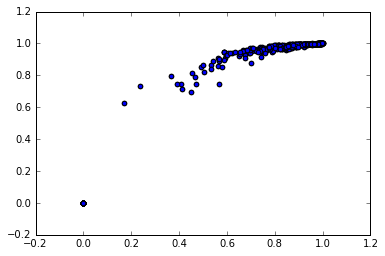

In [263]:
missingness_pos = (pd.isnull(pos).sum(axis=0)/1000)
missingness_smote = (pd.isnull(pos_smote_rest).sum(axis=0)/pos_smote_rest.shape[0])
missingness = pd.concat([missingness_pos, missingness_smote, missingness_pos-missingness_smote], axis=1)
missingness.columns = ["pos", "smote", "pos-smote"]
missingness.to_csv("missingness.csv")
plt.scatter(missingness_pos, missingness_smote)
plt.

## Lets try the same thing but without date difference variables

In [236]:
pos = pd.read_csv("data/pos_train_data.csv")
# delete lookback col
pos.drop("LOOKBACK", axis=1, inplace=True)
pos.drop(pos.columns[343:1026], axis=1, inplace=True)
nns = NN_scipy_missing(pos, nn_k=5)
pos_smote_df = SMOTE_missing(pos, nns, 5)
pos_smote_df = hack_for_binary_flags(pos_smote_df, ["GENDER"])

In [237]:
# Generate 5k positives twice and concatenate them to get 10k new positives
pos_smote_df1 = pos_smote_df
pos_smote_df = SMOTE_missing(pos, nns, 5)
pos_smote_df = hack_for_binary_flags(pos_smote_df, ["GENDER"])
pos_smote_df = pd.concat([pos_smote_df, pos_smote_df1], ignore_index=True)

Ensure that the SMOTE samples have the same variable types as the real ones, i.e. age and date differences are integers, and floats are rounded to 1 decimal place.

In [238]:
pos_smote_df.AGE = pos_smote_df.AGE.apply(np.round, decimals=0)

In [239]:
pos_smote_df.update(pos_smote_df.iloc[:, 2:343].apply(np.round, decimals=1))

Train XGBoost on the training dataset

In [240]:
import xgboost
pos_smote1000 = pos_smote_df.iloc[:1000,:]
pos_smote_rest = pos_smote_df.iloc[1000:,:]
X = pd.concat([pos, pos_smote1000], ignore_index=True)
y = np.hstack((np.ones(1000), np.zeros(1000)))
xr = xgboost.XGBClassifier(n_jobs=-1)
xr.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

How many of the 9k samples look like real positives to the model? __A lot better__.. so basically date difference variables are the ones that are giving synthetic samples away. 

In [241]:
np.sum(xr.predict(pos_smote_rest)==1)

1365

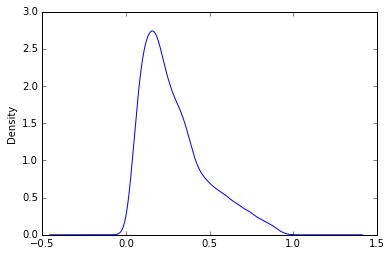

In [242]:
pd.Series(xr.predict_proba(pos_smote_rest)[:,np.argmax(xr.classes_)]).plot(kind="kde")

Save the percentage of zero cells in smote and original dataset

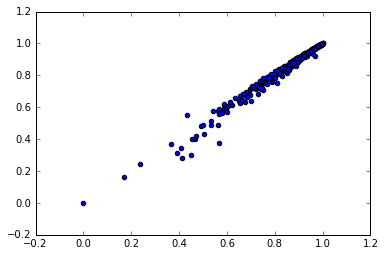

In [252]:
zeroness_pos = ((pos==0).sum(axis=0)/1000)
zeroness_smote = ((pos_smote_rest==0).sum(axis=0)/pos_smote_rest.shape[0])
zeroness = pd.concat([zeroness_pos, zeroness_smote, zeroness_pos-zeroness_smote], axis=1)
zeroness.columns = ["pos", "smote", "pos-smote"]
zeroness.to_csv("zeroness.csv")
plt.scatter(zeroness_pos,zeroness_smote)

## Let's see what's the difference between real and SMOTE patients with LIME

In [243]:
import lime
import lime.lime_tabular
preds = xr.predict_proba(pos_smote_rest)[:, np.argmax(xr.classes_)]
top_3_ix = np.argsort(-preds)[:3]
bottom_3_ix = np.argsort(preds)[:3]
feat_names = list(pos_smote_rest.columns.values.ravel())
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X.values, 
                                                   feature_names=feat_names, 
                                                   class_names=[0, 1], 
                                                   discretize_continuous=True, 
                                                   discretizer = 'decile',
                                                   feature_selection='lasso_path')

This doesn't work for some reason, there's some advice [here](https://github.com/dmlc/xgboost/issues/2334) but couldn't get it to work..

In [162]:
for sample in top_3_ix:
    exp = explainer.explain_instance(pos_smote_rest.iloc[sample].values, xr.predict_proba, num_features=10)
    exp.show_in_notebook(show_table=True, show_all=False)

ValueError: feature_names mismatch: ['AGE', 'GENDER', 'D_7373_AVG_CLAIM_CNT', 'D_7803_AVG_CLAIM_CNT', 'D_7809_AVG_CLAIM_CNT', 'D_7840_AVG_CLAIM_CNT', 'D_7865_AVG_CLAIM_CNT', 'D_7931_AVG_CLAIM_CNT', 'D_4659_AVG_CLAIM_CNT', 'D_7194_AVG_CLAIM_CNT', 'D_7245_AVG_CLAIM_CNT', 'D_V048_AVG_CLAIM_CNT', 'D_V761_AVG_CLAIM_CNT', 'D_2420_AVG_CLAIM_CNT', 'D_2429_AVG_CLAIM_CNT', 'D_2449_AVG_CLAIM_CNT', 'D_2724_AVG_CLAIM_CNT', 'D_4011_AVG_CLAIM_CNT', 'D_4019_AVG_CLAIM_CNT', 'D_5308_AVG_CLAIM_CNT', 'D_7295_AVG_CLAIM_CNT', 'D_7298_AVG_CLAIM_CNT', 'D_V588_AVG_CLAIM_CNT', 'D_7225_AVG_CLAIM_CNT', 'D_7242_AVG_CLAIM_CNT', 'D_7862_AVG_CLAIM_CNT', 'D_3000_AVG_CLAIM_CNT', 'D_496__AVG_CLAIM_CNT', 'D_5188_AVG_CLAIM_CNT', 'D_5990_AVG_CLAIM_CNT', 'D_7291_AVG_CLAIM_CNT', 'D_7806_AVG_CLAIM_CNT', 'D_7807_AVG_CLAIM_CNT', 'D_7860_AVG_CLAIM_CNT', 'D_7879_AVG_CLAIM_CNT', 'D_7890_AVG_CLAIM_CNT', 'D_V723_AVG_CLAIM_CNT', 'D_2689_AVG_CLAIM_CNT', 'D_7288_AVG_CLAIM_CNT', 'D_V586_AVG_CLAIM_CNT', 'D_2500_AVG_CLAIM_CNT', 'D_2720_AVG_CLAIM_CNT', 'D_2859_AVG_CLAIM_CNT', 'D_4010_AVG_CLAIM_CNT', 'D_4660_AVG_CLAIM_CNT', 'D_7062_AVG_CLAIM_CNT', 'D_V700_AVG_CLAIM_CNT', 'D_V726_AVG_CLAIM_CNT', 'D_5640_AVG_CLAIM_CNT', 'D_7021_AVG_CLAIM_CNT', 'D_7231_AVG_CLAIM_CNT', 'D_7805_AVG_CLAIM_CNT', 'D_7820_AVG_CLAIM_CNT', 'D_4939_AVG_CLAIM_CNT', 'D_7812_AVG_CLAIM_CNT', 'D_5859_AVG_CLAIM_CNT', 'D_7821_AVG_CLAIM_CNT', 'D_7883_AVG_CLAIM_CNT', 'D_2962_AVG_CLAIM_CNT', 'D_4932_AVG_CLAIM_CNT', 'D_462__AVG_CLAIM_CNT', 'D_8450_AVG_CLAIM_CNT', 'D_4280_AVG_CLAIM_CNT', 'D_5641_AVG_CLAIM_CNT', 'D_7802_AVG_CLAIM_CNT', 'D_2765_AVG_CLAIM_CNT', 'D_2767_AVG_CLAIM_CNT', 'D_3449_AVG_CLAIM_CNT', 'D_5856_AVG_CLAIM_CNT', 'D_7804_AVG_CLAIM_CNT', 'D_7943_AVG_CLAIM_CNT', 'D_3382_AVG_CLAIM_CNT', 'D_V032_AVG_CLAIM_CNT', 'D_V037_AVG_CLAIM_CNT', 'D_V039_AVG_CLAIM_CNT', 'D_V040_AVG_CLAIM_CNT', 'D_V045_AVG_CLAIM_CNT', 'D_V050_AVG_CLAIM_CNT', 'D_V051_AVG_CLAIM_CNT', 'D_V053_AVG_CLAIM_CNT', 'D_V054_AVG_CLAIM_CNT', 'D_V058_AVG_CLAIM_CNT', 'D_V059_AVG_CLAIM_CNT', 'D_V060_AVG_CLAIM_CNT', 'D_V062_AVG_CLAIM_CNT', 'D_V063_AVG_CLAIM_CNT', 'D_V064_AVG_CLAIM_CNT', 'D_V065_AVG_CLAIM_CNT', 'D_V066_AVG_CLAIM_CNT', 'D_V068_AVG_CLAIM_CNT', 'D_V069_AVG_CLAIM_CNT', 'D_2768_AVG_CLAIM_CNT', 'D_9597_AVG_CLAIM_CNT', 'D_4359_AVG_CLAIM_CNT', 'D_V202_AVG_CLAIM_CNT', 'D_V741_AVG_CLAIM_CNT', 'D_7020_AVG_CLAIM_CNT', 'D_4556_AVG_CLAIM_CNT', 'D_2572_AVG_CLAIM_CNT', 'D_5853_AVG_CLAIM_CNT', 'D_6927_AVG_CLAIM_CNT', 'D_7230_AVG_CLAIM_CNT', 'D_7870_AVG_CLAIM_CNT', 'D_7850_AVG_CLAIM_CNT', 'D_4278_AVG_CLAIM_CNT', 'D_3339_AVG_CLAIM_CNT', 'D_3483_AVG_CLAIM_CNT', 'D_7819_AVG_CLAIM_CNT', 'D_7845_AVG_CLAIM_CNT', 'D_3275_AVG_CLAIM_CNT', 'D_5589_AVG_CLAIM_CNT', 'D_3098_AVG_CLAIM_CNT', 'D_7810_AVG_CLAIM_CNT', 'D_7873_AVG_CLAIM_CNT', 'D_4349_AVG_CLAIM_CNT', 'D_4371_AVG_CLAIM_CNT', 'D_3579_AVG_CLAIM_CNT', 'D_3331_AVG_CLAIM_CNT', 'D_V270_AVG_CLAIM_CNT', 'D_4107_AVG_CLAIM_CNT', 'D_3441_AVG_CLAIM_CNT', 'D_3599_AVG_CLAIM_CNT', 'D_3332_AVG_CLAIM_CNT', 'D_3591_AVG_CLAIM_CNT', 'D_3592_AVG_CLAIM_CNT', 'D_3590_AVG_CLAIM_CNT', 'G_012000_AVG_CLAIM_CNT', 'G_034000_AVG_CLAIM_CNT', 'G_040000_AVG_CLAIM_CNT', 'G_050000_AVG_CLAIM_CNT', 'G_160000_AVG_CLAIM_CNT', 'G_221000_AVG_CLAIM_CNT', 'G_272500_AVG_CLAIM_CNT', 'G_340000_AVG_CLAIM_CNT', 'G_394000_AVG_CLAIM_CNT', 'G_442010_AVG_CLAIM_CNT', 'G_469920_AVG_CLAIM_CNT', 'G_492700_AVG_CLAIM_CNT', 'G_530000_AVG_CLAIM_CNT', 'G_581800_AVG_CLAIM_CNT', 'G_651000_AVG_CLAIM_CNT', 'G_659900_AVG_CLAIM_CNT', 'G_659917_AVG_CLAIM_CNT', 'G_721000_AVG_CLAIM_CNT', 'G_726000_AVG_CLAIM_CNT', 'G_751000_AVG_CLAIM_CNT', 'G_879910_AVG_CLAIM_CNT', 'G_021000_AVG_CLAIM_CNT', 'G_661000_AVG_CLAIM_CNT', 'G_283000_AVG_CLAIM_CNT', 'G_372000_AVG_CLAIM_CNT', 'G_375000_AVG_CLAIM_CNT', 'G_114070_AVG_CLAIM_CNT', 'G_171000_AVG_CLAIM_CNT', 'G_369918_AVG_CLAIM_CNT', 'G_019900_AVG_CLAIM_CNT', 'G_169900_AVG_CLAIM_CNT', 'G_361000_AVG_CLAIM_CNT', 'G_568510_AVG_CLAIM_CNT', 'G_905500_AVG_CLAIM_CNT', 'G_332000_AVG_CLAIM_CNT', 'G_571000_AVG_CLAIM_CNT', 'G_581600_AVG_CLAIM_CNT', 'G_797000_AVG_CLAIM_CNT', 'G_035000_AVG_CLAIM_CNT', 'G_422000_AVG_CLAIM_CNT', 'G_439970_AVG_CLAIM_CNT', 'G_414000_AVG_CLAIM_CNT', 'G_445050_AVG_CLAIM_CNT', 'G_502500_AVG_CLAIM_CNT', 'G_674060_AVG_CLAIM_CNT', 'G_614000_AVG_CLAIM_CNT', 'G_491030_AVG_CLAIM_CNT', 'G_259900_AVG_CLAIM_CNT', 'G_300420_AVG_CLAIM_CNT', 'G_879920_AVG_CLAIM_CNT', 'G_722000_AVG_CLAIM_CNT', 'G_423000_AVG_CLAIM_CNT', 'G_371000_AVG_CLAIM_CNT', 'G_352000_AVG_CLAIM_CNT', 'P_70450_AVG_CLAIM_CNT', 'P_71010_AVG_CLAIM_CNT', 'P_72100_AVG_CLAIM_CNT', 'P_93010_AVG_CLAIM_CNT', 'P_99284_AVG_CLAIM_CNT', 'P_99285_AVG_CLAIM_CNT', 'P_A0425_AVG_CLAIM_CNT', 'P_A0427_AVG_CLAIM_CNT', 'P_73610_AVG_CLAIM_CNT', 'P_77052_AVG_CLAIM_CNT', 'P_90471_AVG_CLAIM_CNT', 'P_99203_AVG_CLAIM_CNT', 'P_99213_AVG_CLAIM_CNT', 'P_99214_AVG_CLAIM_CNT', 'P_99223_AVG_CLAIM_CNT', 'P_99239_AVG_CLAIM_CNT', 'P_G0202_AVG_CLAIM_CNT', 'P_36415_AVG_CLAIM_CNT', 'P_70551_AVG_CLAIM_CNT', 'P_88313_AVG_CLAIM_CNT', 'P_92012_AVG_CLAIM_CNT', 'P_93000_AVG_CLAIM_CNT', 'P_93306_AVG_CLAIM_CNT', 'P_94760_AVG_CLAIM_CNT', 'P_99204_AVG_CLAIM_CNT', 'P_99215_AVG_CLAIM_CNT', 'P_99233_AVG_CLAIM_CNT', 'P_99283_AVG_CLAIM_CNT', 'P_G8553_AVG_CLAIM_CNT', 'P_71020_AVG_CLAIM_CNT', 'P_73130_AVG_CLAIM_CNT', 'P_80053_AVG_CLAIM_CNT', 'P_83735_AVG_CLAIM_CNT', 'P_85025_AVG_CLAIM_CNT', 'P_94010_AVG_CLAIM_CNT', 'P_97001_AVG_CLAIM_CNT', 'P_97110_AVG_CLAIM_CNT', 'P_99205_AVG_CLAIM_CNT', 'P_G0008_AVG_CLAIM_CNT', 'P_G8427_AVG_CLAIM_CNT', 'P_G8978_AVG_CLAIM_CNT', 'P_G8979_AVG_CLAIM_CNT', 'P_93042_AVG_CLAIM_CNT', 'P_97014_AVG_CLAIM_CNT', 'P_97140_AVG_CLAIM_CNT', 'P_99202_AVG_CLAIM_CNT', 'P_99220_AVG_CLAIM_CNT', 'P_99231_AVG_CLAIM_CNT', 'P_99232_AVG_CLAIM_CNT', 'P_99238_AVG_CLAIM_CNT', 'P_99244_AVG_CLAIM_CNT', 'P_99291_AVG_CLAIM_CNT', 'P_92015_AVG_CLAIM_CNT', 'P_99396_AVG_CLAIM_CNT', 'P_80048_AVG_CLAIM_CNT', 'P_80061_AVG_CLAIM_CNT', 'P_82607_AVG_CLAIM_CNT', 'P_84443_AVG_CLAIM_CNT', 'P_90472_AVG_CLAIM_CNT', 'P_90715_AVG_CLAIM_CNT', 'P_96372_AVG_CLAIM_CNT', 'P_31575_AVG_CLAIM_CNT', 'P_51798_AVG_CLAIM_CNT', 'P_70553_AVG_CLAIM_CNT', 'P_76700_AVG_CLAIM_CNT', 'P_76942_AVG_CLAIM_CNT', 'P_81003_AVG_CLAIM_CNT', 'P_99212_AVG_CLAIM_CNT', 'P_99243_AVG_CLAIM_CNT', 'P_99245_AVG_CLAIM_CNT', 'P_72141_AVG_CLAIM_CNT', 'P_85652_AVG_CLAIM_CNT', 'P_93880_AVG_CLAIM_CNT', 'P_99222_AVG_CLAIM_CNT', 'P_80050_AVG_CLAIM_CNT', 'P_81025_AVG_CLAIM_CNT', 'P_86580_AVG_CLAIM_CNT', 'P_99420_AVG_CLAIM_CNT', 'P_84165_AVG_CLAIM_CNT', 'P_72148_AVG_CLAIM_CNT', 'P_99254_AVG_CLAIM_CNT', 'P_84439_AVG_CLAIM_CNT', 'P_90686_AVG_CLAIM_CNT', 'P_17000_AVG_CLAIM_CNT', 'P_85018_AVG_CLAIM_CNT', 'P_95811_AVG_CLAIM_CNT', 'P_82962_AVG_CLAIM_CNT', 'P_84550_AVG_CLAIM_CNT', 'P_86038_AVG_CLAIM_CNT', 'P_84484_AVG_CLAIM_CNT', 'P_A4550_AVG_CLAIM_CNT', 'P_1101F_AVG_CLAIM_CNT', 'P_95886_AVG_CLAIM_CNT', 'P_82550_AVG_CLAIM_CNT', 'P_98941_AVG_CLAIM_CNT', 'P_36620_AVG_CLAIM_CNT', 'P_74230_AVG_CLAIM_CNT', 'P_83891_AVG_CLAIM_CNT', 'P_83912_AVG_CLAIM_CNT', 'P_95913_AVG_CLAIM_CNT', 'P_90862_AVG_CLAIM_CNT', 'P_74176_AVG_CLAIM_CNT', 'P_99053_AVG_CLAIM_CNT', 'P_74177_AVG_CLAIM_CNT', 'P_84480_AVG_CLAIM_CNT', 'P_76705_AVG_CLAIM_CNT', 'P_93272_AVG_CLAIM_CNT', 'P_E0973_AVG_CLAIM_CNT', 'P_59025_AVG_CLAIM_CNT', 'P_99354_AVG_CLAIM_CNT', 'P_83909_AVG_CLAIM_CNT', 'P_95810_AVG_CLAIM_CNT', 'P_95885_AVG_CLAIM_CNT', 'P_95911_AVG_CLAIM_CNT', 'P_83519_AVG_CLAIM_CNT', 'P_76857_AVG_CLAIM_CNT', 'P_72157_AVG_CLAIM_CNT', 'P_62270_AVG_CLAIM_CNT', 'P_95908_AVG_CLAIM_CNT', 'P_96110_AVG_CLAIM_CNT', 'P_L2275_AVG_CLAIM_CNT', 'S_S21_AVG_CLAIM', 'S_S22_AVG_CLAIM', 'S_S45_AVG_CLAIM', 'S_S05_AVG_CLAIM', 'S_S24_AVG_CLAIM', 'S_S37_AVG_CLAIM', 'S_S53_AVG_CLAIM', 'S_S04_AVG_CLAIM', 'S_S08_AVG_CLAIM', 'S_S23_AVG_CLAIM', 'S_S44_AVG_CLAIM', 'S_S48_AVG_CLAIM', 'S_S51_AVG_CLAIM', 'S_S75_AVG_CLAIM', 'S_S67_AVG_CLAIM', 'S_S34_AVG_CLAIM', 'S_S66_AVG_CLAIM', 'S_S73_AVG_CLAIM', 'S_S76_AVG_CLAIM', 'S_S38_AVG_CLAIM', 'S_S49_AVG_CLAIM', 'S_S65_AVG_CLAIM', 'S_S70_AVG_CLAIM', 'S_S19_AVG_CLAIM', 'S_S69_AVG_CLAIM', 'S_S25_AVG_CLAIM', 'S_S55_AVG_CLAIM', 'S_S82_AVG_CLAIM', 'S_S26_AVG_CLAIM', 'S_S39_AVG_CLAIM', 'S_S52_AVG_CLAIM', 'S_S64_AVG_CLAIM', 'S_S83_AVG_CLAIM', 'S_S02_AVG_CLAIM', 'S_S42_AVG_CLAIM', 'S_S30_AVG_CLAIM', 'S_S12_AVG_CLAIM', 'S_S29_AVG_CLAIM', 'S_S57_AVG_CLAIM', 'S_S14_AVG_CLAIM', 'S_S59_AVG_CLAIM', 'S_S11_AVG_CLAIM'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342']
expected S_S52_AVG_CLAIM, G_160000_AVG_CLAIM_CNT, G_371000_AVG_CLAIM_CNT, P_85018_AVG_CLAIM_CNT, G_414000_AVG_CLAIM_CNT, P_G8978_AVG_CLAIM_CNT, P_99223_AVG_CLAIM_CNT, D_V037_AVG_CLAIM_CNT, D_3579_AVG_CLAIM_CNT, P_71020_AVG_CLAIM_CNT, P_99232_AVG_CLAIM_CNT, G_034000_AVG_CLAIM_CNT, S_S11_AVG_CLAIM, G_722000_AVG_CLAIM_CNT, P_93000_AVG_CLAIM_CNT, P_99215_AVG_CLAIM_CNT, D_5990_AVG_CLAIM_CNT, P_73130_AVG_CLAIM_CNT, P_82962_AVG_CLAIM_CNT, D_3591_AVG_CLAIM_CNT, P_72100_AVG_CLAIM_CNT, P_95886_AVG_CLAIM_CNT, P_93042_AVG_CLAIM_CNT, S_S19_AVG_CLAIM, P_99396_AVG_CLAIM_CNT, D_3339_AVG_CLAIM_CNT, D_7807_AVG_CLAIM_CNT, S_S53_AVG_CLAIM, D_2724_AVG_CLAIM_CNT, S_S76_AVG_CLAIM, P_99243_AVG_CLAIM_CNT, D_3382_AVG_CLAIM_CNT, D_7225_AVG_CLAIM_CNT, D_7860_AVG_CLAIM_CNT, D_2962_AVG_CLAIM_CNT, P_99053_AVG_CLAIM_CNT, D_V040_AVG_CLAIM_CNT, P_99222_AVG_CLAIM_CNT, P_90471_AVG_CLAIM_CNT, S_S29_AVG_CLAIM, P_95908_AVG_CLAIM_CNT, G_797000_AVG_CLAIM_CNT, P_99420_AVG_CLAIM_CNT, S_S83_AVG_CLAIM, D_3441_AVG_CLAIM_CNT, D_V741_AVG_CLAIM_CNT, D_3332_AVG_CLAIM_CNT, G_659917_AVG_CLAIM_CNT, S_S57_AVG_CLAIM, P_99212_AVG_CLAIM_CNT, G_659900_AVG_CLAIM_CNT, D_7242_AVG_CLAIM_CNT, P_51798_AVG_CLAIM_CNT, S_S70_AVG_CLAIM, P_72157_AVG_CLAIM_CNT, S_S25_AVG_CLAIM, P_83909_AVG_CLAIM_CNT, P_93010_AVG_CLAIM_CNT, G_442010_AVG_CLAIM_CNT, P_81025_AVG_CLAIM_CNT, P_G0202_AVG_CLAIM_CNT, P_17000_AVG_CLAIM_CNT, S_S12_AVG_CLAIM, S_S04_AVG_CLAIM, P_99354_AVG_CLAIM_CNT, P_99254_AVG_CLAIM_CNT, G_050000_AVG_CLAIM_CNT, S_S64_AVG_CLAIM, P_74176_AVG_CLAIM_CNT, D_5188_AVG_CLAIM_CNT, P_94760_AVG_CLAIM_CNT, D_9597_AVG_CLAIM_CNT, S_S34_AVG_CLAIM, S_S21_AVG_CLAIM, D_2420_AVG_CLAIM_CNT, D_5589_AVG_CLAIM_CNT, G_491030_AVG_CLAIM_CNT, G_530000_AVG_CLAIM_CNT, S_S44_AVG_CLAIM, D_7288_AVG_CLAIM_CNT, D_7295_AVG_CLAIM_CNT, P_90862_AVG_CLAIM_CNT, S_S51_AVG_CLAIM, P_99291_AVG_CLAIM_CNT, D_V058_AVG_CLAIM_CNT, G_114070_AVG_CLAIM_CNT, P_L2275_AVG_CLAIM_CNT, G_352000_AVG_CLAIM_CNT, D_5853_AVG_CLAIM_CNT, D_V202_AVG_CLAIM_CNT, P_99203_AVG_CLAIM_CNT, P_81003_AVG_CLAIM_CNT, G_905500_AVG_CLAIM_CNT, P_G8979_AVG_CLAIM_CNT, D_2572_AVG_CLAIM_CNT, P_31575_AVG_CLAIM_CNT, P_93880_AVG_CLAIM_CNT, G_751000_AVG_CLAIM_CNT, P_76857_AVG_CLAIM_CNT, G_021000_AVG_CLAIM_CNT, P_97140_AVG_CLAIM_CNT, D_7021_AVG_CLAIM_CNT, P_E0973_AVG_CLAIM_CNT, D_3098_AVG_CLAIM_CNT, P_99214_AVG_CLAIM_CNT, S_S59_AVG_CLAIM, P_1101F_AVG_CLAIM_CNT, G_040000_AVG_CLAIM_CNT, P_96110_AVG_CLAIM_CNT, D_4011_AVG_CLAIM_CNT, G_581600_AVG_CLAIM_CNT, G_502500_AVG_CLAIM_CNT, D_5856_AVG_CLAIM_CNT, G_283000_AVG_CLAIM_CNT, D_7840_AVG_CLAIM_CNT, S_S39_AVG_CLAIM, P_95913_AVG_CLAIM_CNT, P_59025_AVG_CLAIM_CNT, P_G0008_AVG_CLAIM_CNT, G_674060_AVG_CLAIM_CNT, D_7020_AVG_CLAIM_CNT, P_82607_AVG_CLAIM_CNT, P_G8553_AVG_CLAIM_CNT, D_8450_AVG_CLAIM_CNT, P_99245_AVG_CLAIM_CNT, P_86038_AVG_CLAIM_CNT, D_2500_AVG_CLAIM_CNT, P_70553_AVG_CLAIM_CNT, G_300420_AVG_CLAIM_CNT, G_169900_AVG_CLAIM_CNT, D_2720_AVG_CLAIM_CNT, D_2449_AVG_CLAIM_CNT, D_7850_AVG_CLAIM_CNT, P_92012_AVG_CLAIM_CNT, S_S45_AVG_CLAIM, D_V048_AVG_CLAIM_CNT, P_96372_AVG_CLAIM_CNT, S_S23_AVG_CLAIM, D_7812_AVG_CLAIM_CNT, P_G8427_AVG_CLAIM_CNT, D_V588_AVG_CLAIM_CNT, S_S49_AVG_CLAIM, D_V062_AVG_CLAIM_CNT, D_5308_AVG_CLAIM_CNT, D_4280_AVG_CLAIM_CNT, S_S26_AVG_CLAIM, D_7804_AVG_CLAIM_CNT, D_V045_AVG_CLAIM_CNT, D_7298_AVG_CLAIM_CNT, P_95911_AVG_CLAIM_CNT, D_7231_AVG_CLAIM_CNT, P_99239_AVG_CLAIM_CNT, D_7803_AVG_CLAIM_CNT, D_2859_AVG_CLAIM_CNT, D_V700_AVG_CLAIM_CNT, P_72148_AVG_CLAIM_CNT, P_95885_AVG_CLAIM_CNT, P_36620_AVG_CLAIM_CNT, S_S14_AVG_CLAIM, D_V586_AVG_CLAIM_CNT, D_2429_AVG_CLAIM_CNT, D_V068_AVG_CLAIM_CNT, G_375000_AVG_CLAIM_CNT, P_90472_AVG_CLAIM_CNT, P_85025_AVG_CLAIM_CNT, D_2765_AVG_CLAIM_CNT, G_035000_AVG_CLAIM_CNT, P_99285_AVG_CLAIM_CNT, G_879920_AVG_CLAIM_CNT, D_2768_AVG_CLAIM_CNT, P_84443_AVG_CLAIM_CNT, D_4349_AVG_CLAIM_CNT, D_5859_AVG_CLAIM_CNT, G_171000_AVG_CLAIM_CNT, G_019900_AVG_CLAIM_CNT, D_4939_AVG_CLAIM_CNT, S_S08_AVG_CLAIM, P_74177_AVG_CLAIM_CNT, D_V053_AVG_CLAIM_CNT, AGE, D_4278_AVG_CLAIM_CNT, D_7873_AVG_CLAIM_CNT, G_332000_AVG_CLAIM_CNT, S_S75_AVG_CLAIM, D_7062_AVG_CLAIM_CNT, P_83912_AVG_CLAIM_CNT, P_88313_AVG_CLAIM_CNT, D_7245_AVG_CLAIM_CNT, S_S55_AVG_CLAIM, P_76705_AVG_CLAIM_CNT, D_3599_AVG_CLAIM_CNT, D_7890_AVG_CLAIM_CNT, D_7194_AVG_CLAIM_CNT, D_V039_AVG_CLAIM_CNT, G_581800_AVG_CLAIM_CNT, P_99205_AVG_CLAIM_CNT, P_73610_AVG_CLAIM_CNT, D_4359_AVG_CLAIM_CNT, P_99244_AVG_CLAIM_CNT, P_80061_AVG_CLAIM_CNT, G_439970_AVG_CLAIM_CNT, D_7806_AVG_CLAIM_CNT, D_7819_AVG_CLAIM_CNT, D_4107_AVG_CLAIM_CNT, P_90686_AVG_CLAIM_CNT, G_614000_AVG_CLAIM_CNT, D_7805_AVG_CLAIM_CNT, D_4371_AVG_CLAIM_CNT, S_S38_AVG_CLAIM, D_V050_AVG_CLAIM_CNT, P_92015_AVG_CLAIM_CNT, D_3331_AVG_CLAIM_CNT, D_6927_AVG_CLAIM_CNT, S_S65_AVG_CLAIM, D_V270_AVG_CLAIM_CNT, P_72141_AVG_CLAIM_CNT, P_90715_AVG_CLAIM_CNT, P_99231_AVG_CLAIM_CNT, D_V051_AVG_CLAIM_CNT, P_97001_AVG_CLAIM_CNT, D_5640_AVG_CLAIM_CNT, P_A0425_AVG_CLAIM_CNT, D_7291_AVG_CLAIM_CNT, D_7883_AVG_CLAIM_CNT, D_V069_AVG_CLAIM_CNT, G_651000_AVG_CLAIM_CNT, D_V065_AVG_CLAIM_CNT, D_7870_AVG_CLAIM_CNT, D_V726_AVG_CLAIM_CNT, P_99202_AVG_CLAIM_CNT, P_83891_AVG_CLAIM_CNT, D_7230_AVG_CLAIM_CNT, G_369918_AVG_CLAIM_CNT, G_361000_AVG_CLAIM_CNT, D_V032_AVG_CLAIM_CNT, D_V059_AVG_CLAIM_CNT, P_36415_AVG_CLAIM_CNT, D_V066_AVG_CLAIM_CNT, S_S22_AVG_CLAIM, D_7865_AVG_CLAIM_CNT, S_S48_AVG_CLAIM, G_568510_AVG_CLAIM_CNT, G_221000_AVG_CLAIM_CNT, D_3592_AVG_CLAIM_CNT, P_83519_AVG_CLAIM_CNT, D_V723_AVG_CLAIM_CNT, D_4010_AVG_CLAIM_CNT, D_7820_AVG_CLAIM_CNT, P_97014_AVG_CLAIM_CNT, D_5641_AVG_CLAIM_CNT, G_469920_AVG_CLAIM_CNT, D_7802_AVG_CLAIM_CNT, P_86580_AVG_CLAIM_CNT, D_V060_AVG_CLAIM_CNT, GENDER, S_S05_AVG_CLAIM, S_S82_AVG_CLAIM, S_S30_AVG_CLAIM, D_3275_AVG_CLAIM_CNT, P_84165_AVG_CLAIM_CNT, P_99284_AVG_CLAIM_CNT, S_S02_AVG_CLAIM, D_V064_AVG_CLAIM_CNT, D_7943_AVG_CLAIM_CNT, D_2689_AVG_CLAIM_CNT, S_S37_AVG_CLAIM, P_A4550_AVG_CLAIM_CNT, P_84484_AVG_CLAIM_CNT, G_879910_AVG_CLAIM_CNT, P_83735_AVG_CLAIM_CNT, G_423000_AVG_CLAIM_CNT, P_95810_AVG_CLAIM_CNT, D_V761_AVG_CLAIM_CNT, D_4019_AVG_CLAIM_CNT, P_84550_AVG_CLAIM_CNT, S_S42_AVG_CLAIM, P_62270_AVG_CLAIM_CNT, P_84480_AVG_CLAIM_CNT, P_71010_AVG_CLAIM_CNT, D_4660_AVG_CLAIM_CNT, P_76942_AVG_CLAIM_CNT, G_422000_AVG_CLAIM_CNT, P_98941_AVG_CLAIM_CNT, P_76700_AVG_CLAIM_CNT, D_V063_AVG_CLAIM_CNT, D_3449_AVG_CLAIM_CNT, P_74230_AVG_CLAIM_CNT, G_340000_AVG_CLAIM_CNT, G_721000_AVG_CLAIM_CNT, D_462__AVG_CLAIM_CNT, S_S69_AVG_CLAIM, G_661000_AVG_CLAIM_CNT, S_S67_AVG_CLAIM, P_80050_AVG_CLAIM_CNT, P_94010_AVG_CLAIM_CNT, P_93272_AVG_CLAIM_CNT, P_99220_AVG_CLAIM_CNT, D_4932_AVG_CLAIM_CNT, D_4556_AVG_CLAIM_CNT, P_80048_AVG_CLAIM_CNT, P_95811_AVG_CLAIM_CNT, G_445050_AVG_CLAIM_CNT, P_99213_AVG_CLAIM_CNT, D_4659_AVG_CLAIM_CNT, S_S73_AVG_CLAIM, P_97110_AVG_CLAIM_CNT, D_3590_AVG_CLAIM_CNT, G_259900_AVG_CLAIM_CNT, D_7862_AVG_CLAIM_CNT, P_99283_AVG_CLAIM_CNT, G_492700_AVG_CLAIM_CNT, G_272500_AVG_CLAIM_CNT, D_3000_AVG_CLAIM_CNT, D_7879_AVG_CLAIM_CNT, P_99204_AVG_CLAIM_CNT, D_7373_AVG_CLAIM_CNT, D_7845_AVG_CLAIM_CNT, P_80053_AVG_CLAIM_CNT, D_7810_AVG_CLAIM_CNT, P_93306_AVG_CLAIM_CNT, D_7931_AVG_CLAIM_CNT, D_7821_AVG_CLAIM_CNT, P_99233_AVG_CLAIM_CNT, D_496__AVG_CLAIM_CNT, P_77052_AVG_CLAIM_CNT, G_372000_AVG_CLAIM_CNT, G_726000_AVG_CLAIM_CNT, D_7809_AVG_CLAIM_CNT, D_V054_AVG_CLAIM_CNT, S_S24_AVG_CLAIM, G_571000_AVG_CLAIM_CNT, P_84439_AVG_CLAIM_CNT, S_S66_AVG_CLAIM, D_2767_AVG_CLAIM_CNT, D_3483_AVG_CLAIM_CNT, P_70551_AVG_CLAIM_CNT, P_70450_AVG_CLAIM_CNT, P_A0427_AVG_CLAIM_CNT, P_99238_AVG_CLAIM_CNT, G_012000_AVG_CLAIM_CNT, P_85652_AVG_CLAIM_CNT, G_394000_AVG_CLAIM_CNT, P_82550_AVG_CLAIM_CNT in input data
training data did not have the following fields: f272, f163, f182, f167, f308, f149, f217, f70, f136, f6, f244, f320, f294, f337, f262, f224, f22, f51, f330, f338, f94, f264, f254, f62, f280, f37, f336, f122, f211, f58, f218, f229, f60, f138, f215, f143, f258, f20, f130, f26, f32, f263, f243, f48, f335, f172, f73, f157, f7, f189, f181, f13, f123, f253, f194, f212, f137, f151, f104, f59, f283, f184, f148, f38, f328, f210, f240, f307, f74, f82, f274, f28, f230, f146, f209, f205, f169, f144, f14, f268, f100, f9, f156, f255, f118, f287, f124, f270, f186, f199, f54, f86, f142, f63, f61, f129, f196, f0, f326, f95, f190, f242, f27, f150, f250, f237, f312, f238, f12, f265, f195, f57, f257, f203, f1, f3, f233, f66, f50, f65, f39, f175, f332, f223, f98, f187, f191, f81, f106, f41, f78, f97, f299, f91, f131, f315, f101, f183, f71, f56, f296, f282, f281, f24, f285, f154, f107, f171, f342, f221, f110, f99, f252, f220, f114, f162, f289, f40, f200, f207, f139, f147, f333, f145, f288, f68, f304, f25, f321, f11, f178, f10, f301, f164, f317, f64, f72, f316, f158, f161, f21, f90, f15, f113, f241, f67, f47, f109, f231, f235, f31, f295, f85, f246, f249, f16, f69, f247, f166, f331, f84, f18, f226, f36, f309, f185, f168, f119, f334, f227, f155, f17, f160, f134, f292, f279, f179, f103, f213, f291, f34, f173, f271, f325, f49, f225, f232, f19, f115, f23, f256, f30, f44, f117, f125, f329, f339, f267, f112, f111, f83, f42, f202, f46, f75, f76, f29, f121, f153, f108, f89, f239, f293, f303, f341, f340, f87, f245, f319, f208, f260, f216, f128, f35, f248, f176, f236, f297, f300, f259, f266, f33, f140, f170, f284, f92, f105, f314, f174, f278, f43, f298, f222, f53, f133, f204, f8, f290, f201, f327, f132, f197, f198, f52, f251, f88, f2, f214, f79, f80, f165, f152, f219, f4, f96, f275, f310, f126, f188, f135, f311, f322, f306, f324, f234, f141, f269, f193, f261, f177, f93, f127, f318, f206, f102, f116, f5, f159, f192, f277, f45, f77, f276, f305, f120, f302, f55, f180, f313, f323, f286, f273, f228

In [146]:
for sample in bottom_3_ix:
    exp = explainer.explain_instance(pos_smote_rest.iloc[sample], xr.predict_proba, num_features=10)
    exp.show_in_notebook(show_table=True, show_all=False)

KeyError: 3008